<a href="https://colab.research.google.com/github/R3gm/InsightSolver-Colab/blob/main/Wonder_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wonder 3D: Single Image to 3D using Cross-Domain Diffusion

Wonder3D proposing a cross-domain diffusion model that generates multiview normal maps and color images.



| Code Credits | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/xxlong0/Wonder3D?style=social)](https://github.com/xxlong0/Wonder3D) |
| 🚀 Online inference | [![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo) |
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/InsightSolver-Colab/) |



In [ ]:
!pip3 install torch torchvision torchaudio xformers==0.0.22.post4 --index-url https://download.pytorch.org/whl/cu118
!pip install fire diffusers==0.19.3 transformers bitsandbytes accelerate gradio rembg segment_anything icecream==2.1.0 pyhocon==0.3.57
!pip install einops omegaconf pytorch-lightning==1.9.5 torch_efficient_distloss nerfacc==0.3.3 PyMCubes trimesh

!git clone https://github.com/xxlong0/Wonder3D
%cd Wonder3D/
!git checkout c37ff0e5389553cbf8ddc1c37a9183ecf5dcb012 # commit stable version

## Download models

In [ ]:
import os
!apt -y install -qq aria2

def download_file(url, destination_folder, output_filename):
    command = f"aria2c --console-log-level=error --summary-interval=10 -c -x 16 -k 1M -s 16 {url} -d {destination_folder} -o {output_filename}"
    os.system(command)

revision = "c63ae58e2ea86f6f6f57cc905f33f474e42fcdd5"

# Example usage
urls = [
    f"https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/{revision}/ckpts/random_states_0.pkl",
    f"https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/{revision}/ckpts/scaler.pt",
    f"https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/{revision}/ckpts/scheduler.bin",
    f"https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/{revision}/ckpts/unet/diffusion_pytorch_model.bin",
    f"https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/{revision}/ckpts/unet/config.json",
    f"https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/{revision}/sam_pt/sam_vit_h_4b8939.pth"
]

destination_folders = [
    "/content/Wonder3D/ckpts",
    "/content/Wonder3D/ckpts",
    "/content/Wonder3D/ckpts",
    "/content/Wonder3D/ckpts/unet",
    "/content/Wonder3D/ckpts/unet",
    "/content/Wonder3D/sam_pt"
]

output_filenames = [
    "random_states_0.pkl",
    "scaler.pt",
    "scheduler.bin",
    "diffusion_pytorch_model.bin",
    "config.json",
    "sam_vit_h_4b8939.pth"
]

for i in range(len(urls)):
    download_file(urls[i], destination_folders[i], output_filenames[i])

Import libraries and configure the number of views.

In [ ]:
%cd /content/Wonder3D
import os
import torch
import fire
import gradio as gr
from PIL import Image
from functools import partial

import cv2
import time
import numpy as np
from rembg import remove
from segment_anything import sam_model_registry, SamPredictor

import os, gc, sys, numpy, torch, rembg, threading, urllib.request
from PIL import Image
from typing import Dict, Optional, Tuple, List
from dataclasses import dataclass
import huggingface_hub
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from mvdiffusion.models.unet_mv2d_condition import UNetMV2DConditionModel
from mvdiffusion.data.single_image_dataset import SingleImageDataset as MVDiffusionDataset
from mvdiffusion.pipelines.pipeline_mvdiffusion_image import MVDiffusionImagePipeline
from diffusers import AutoencoderKL, DDPMScheduler, DDIMScheduler
from einops import rearrange
import numpy as np

if not hasattr(Image, 'Resampling'):
    Image.Resampling = Image

num_views = 6 # 4 or 6 # soon 12
weight_dtype = torch.float16
_GPU_ID = 0

/content/Wonder3D


## Load pipeline


 Several components of the pipeline corresponding to [Stable Diffusion Image Variations](https://huggingface.co/lambdalabs/sd-image-variations-diffusers)


In [ ]:
def load_wonder3d_pipeline(num_views, weight_dtype):
    pretrained_model_name_or_path = 'lambdalabs/sd-image-variations-diffusers'
    pretrained_unet_path = './ckpts/'
    revision = "main"
    # Load scheduler, tokenizer and models.
    # noise_scheduler = DDPMScheduler.from_pretrained(cfg.pretrained_model_name_or_path, subfolder="scheduler")
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(pretrained_model_name_or_path, subfolder="image_encoder", revision=revision)
    feature_extractor = CLIPImageProcessor.from_pretrained(pretrained_model_name_or_path, subfolder="feature_extractor", revision=revision)
    vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision)

    unet = UNetMV2DConditionModel.from_pretrained_2d(
        pretrained_unet_path,
        subfolder="unet",
        revision=revision,
        camera_embedding_type = 'e_de_da_sincos',
        projection_class_embeddings_input_dim = 10,
        num_views = num_views,
        sample_size = 32,
        zero_init_conv_in = False,
        zero_init_camera_projection = False,
    )
    unet.enable_xformers_memory_efficient_attention()

    # Move text_encode and vae to gpu and cast to weight_dtype
    image_encoder.to(dtype=weight_dtype)
    vae.to(dtype=weight_dtype)
    unet.to(dtype=weight_dtype)

    pipeline = MVDiffusionImagePipeline(
        image_encoder=image_encoder, feature_extractor=feature_extractor, vae=vae, unet=unet, safety_checker=None,
        scheduler=DDIMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler"),
        camera_embedding_type = 'e_de_da_sincos',
        num_views = num_views,
    )

    if torch.cuda.is_available():
        pipeline.to('cuda:0')

    return pipeline

# Load pipe
pipeline = load_wonder3d_pipeline(num_views, weight_dtype)
torch.set_grad_enabled(False)
pipeline.to(f'cuda:{_GPU_ID}')


Load the Segment Anything model (SAM).

In [ ]:
def sam_init():
    sam_checkpoint = os.path.join("/content/Wonder3D/sam_pt/sam_vit_h_4b8939.pth")
    model_type = "vit_h"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=f"cuda:{_GPU_ID}")
    predictor = SamPredictor(sam)
    return predictor


predictor = sam_init()

## Select an image

Use the example images or download another one and assign it to the variable input_image.

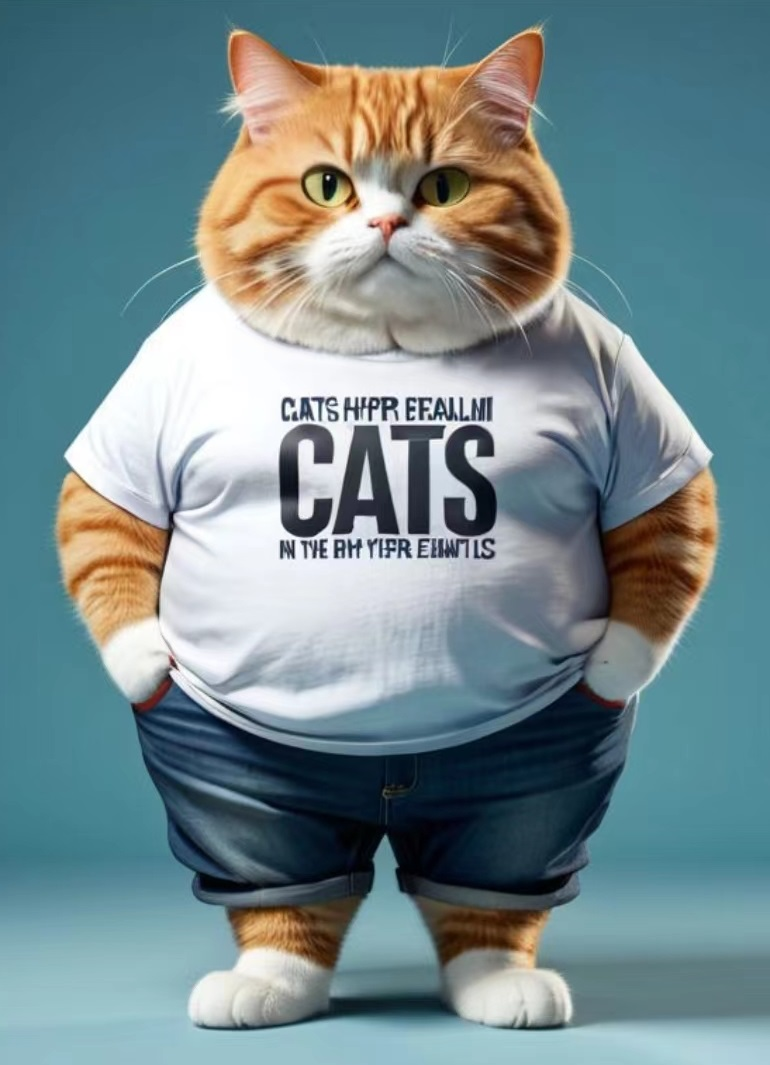

In [ ]:
!wget "https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/main/example_images/000-cat.jpg" -O image_test.jpg -q
#!wget "https://huggingface.co/spaces/flamehaze1115/Wonder3D-demo/resolve/main/example_images/000-chair.jpg" -O image_test.jpg -q

from PIL import Image
input_image = Image.open("image_test.jpg")
#input_image = input_image.resize((512, 512))
input_image

## SAM preprocess

Detect the most representative object in the image and remove its background.

SAM Time: 2.155s


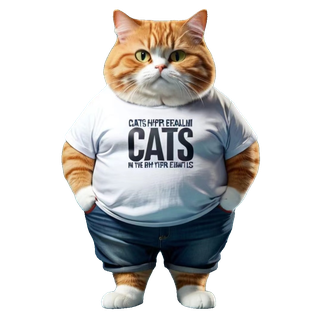

In [ ]:
def sam_segment(predictor, input_image, *bbox_coords):
    bbox = np.array(bbox_coords)
    image = np.asarray(input_image)

    start_time = time.time()
    predictor.set_image(image)

    masks_bbox, scores_bbox, logits_bbox = predictor.predict(
        box=bbox,
        multimask_output=True
    )

    print(f"SAM Time: {time.time() - start_time:.3f}s")
    out_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    out_image[:, :, :3] = image
    out_image_bbox = out_image.copy()
    out_image_bbox[:, :, 3] = masks_bbox[-1].astype(np.uint8) * 255
    torch.cuda.empty_cache()
    return Image.fromarray(out_image_bbox, mode='RGBA')

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

def preprocess(predictor, input_image, segment=True, rescale=False):
    RES = 1024
    input_image.thumbnail([RES, RES], Image.Resampling.LANCZOS)
    # if chk_group is not None:
    #     segment = "Background Removal" in chk_group
    #     rescale = "Rescale" in chk_group
    if segment:
        image_rem = input_image.convert('RGBA')
        image_nobg = remove(image_rem, alpha_matting=True)
        arr = np.asarray(image_nobg)[:,:,-1]
        x_nonzero = np.nonzero(arr.sum(axis=0))
        y_nonzero = np.nonzero(arr.sum(axis=1))
        x_min = int(x_nonzero[0].min())
        y_min = int(y_nonzero[0].min())
        x_max = int(x_nonzero[0].max())
        y_max = int(y_nonzero[0].max())
        input_image = sam_segment(predictor, input_image.convert('RGB'), x_min, y_min, x_max, y_max)
    # Rescale and recenter
    if rescale:
        image_arr = np.array(input_image)
        in_w, in_h = image_arr.shape[:2]
        out_res = min(RES, max(in_w, in_h))
        ret, mask = cv2.threshold(np.array(input_image.split()[-1]), 0, 255, cv2.THRESH_BINARY)
        x, y, w, h = cv2.boundingRect(mask)
        max_size = max(w, h)
        ratio = 0.75
        side_len = int(max_size / ratio)
        padded_image = np.zeros((side_len, side_len, 4), dtype=np.uint8)
        center = side_len//2
        padded_image[center-h//2:center-h//2+h, center-w//2:center-w//2+w] = image_arr[y:y+h, x:x+w]
        rgba = Image.fromarray(padded_image).resize((out_res, out_res), Image.LANCZOS)

        rgba_arr = np.array(rgba) / 255.0
        rgb = rgba_arr[...,:3] * rgba_arr[...,-1:] + (1 - rgba_arr[...,-1:])
        input_image = Image.fromarray((rgb * 255).astype(np.uint8))
    else:
        input_image = expand2square(input_image, (127, 127, 127, 0))
    return input_image, input_image.resize((320, 320), Image.Resampling.LANCZOS)

# Segmentation with SAM
processed_image_highres, processed_image = preprocess(
    predictor,
    input_image,
    segment=True, # remove background
    rescale=False
)
processed_image

## Run the pipeline to obtain the views

In [ ]:
from mvdiffusion.data.single_image_dataset import SingleImageDataset
def prepare_data(single_image, crop_size):
    dataset = SingleImageDataset(
        root_dir = None,
        num_views = 6,
        img_wh=[256, 256],
        bg_color='white',
        crop_size=crop_size,
        single_image=single_image
    )
    return dataset[0]

def save_image(tensor, fp):
    ndarr = tensor.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    # pdb.set_trace()
    im = Image.fromarray(ndarr)
    im.save(fp)
    return ndarr, im

def save_image_numpy(ndarr, fp):
    im = Image.fromarray(ndarr)
    im.save(fp)

def run_pipeline(pipeline, single_image, guidance_scale, steps, seed, crop_size, save_dir, scene_name, num_views):
    import pdb
    # pdb.set_trace()

    batch = prepare_data(single_image, crop_size)

    #pipeline.set_progress_bar_config(disable=True)

    seed = int(seed)
    generator = torch.Generator(device=pipeline.unet.device).manual_seed(seed)

    # repeat  (2B, Nv, 3, H, W)
    imgs_in = torch.cat([batch['imgs_in']]*2, dim=0).to(weight_dtype)

    # (2B, Nv, Nce)
    camera_embeddings = torch.cat([batch['camera_embeddings']]*2, dim=0).to(weight_dtype)

    task_embeddings = torch.cat([batch['normal_task_embeddings'], batch['color_task_embeddings']], dim=0).to(weight_dtype)

    camera_embeddings = torch.cat([camera_embeddings, task_embeddings], dim=-1).to(weight_dtype)

    # (B*Nv, 3, H, W)
    imgs_in = rearrange(imgs_in, "Nv C H W -> (Nv) C H W")
    # (B*Nv, Nce)
    # camera_embeddings = rearrange(camera_embeddings, "B Nv Nce -> (B Nv) Nce")

    out = pipeline(
        imgs_in, camera_embeddings, generator=generator, guidance_scale=guidance_scale,
        num_inference_steps=steps,
        output_type='pt', num_images_per_prompt=1, eta=1.0
    ).images

    bsz = out.shape[0] // 2
    normals_pred = out[:bsz]
    images_pred = out[bsz:]

    cur_dir = os.path.join(save_dir, f"cropsize-{crop_size}-cfg{guidance_scale:.1f}")

    if num_views == 6:
        VIEWS = ['front', 'front_right', 'right', 'back', 'left', 'front_left']
    elif num_views == 4:
        VIEWS = ['front', 'right', 'back', 'left']

    images = []
    for i in range(bsz//num_views):
        scene = scene_name
        scene_dir = os.path.join(cur_dir, scene)
        normal_dir = os.path.join(scene_dir, "normals")
        masked_colors_dir = os.path.join(scene_dir, "masked_colors")
        os.makedirs(normal_dir, exist_ok=True)
        os.makedirs(masked_colors_dir, exist_ok=True)

        for j in range(num_views):
            view = VIEWS[j]
            idx = i*num_views + j
            normal = normals_pred[idx]
            color = images_pred[idx]

            normal_filename = f"normals_000_{view}.png"
            rgb_filename = f"rgb_000_{view}.png"
            normal, pil_n = save_image(normal, os.path.join(normal_dir, normal_filename))
            color, pil_c = save_image(color, os.path.join(scene_dir, rgb_filename))
            images.append(pil_c)
            images.append(pil_n)

            rm_normal = remove(normal)
            rm_color = remove(color)

            save_image_numpy(rm_normal, os.path.join(scene_dir, normal_filename))
            save_image_numpy(rm_color, os.path.join(masked_colors_dir, rgb_filename))

    torch.cuda.empty_cache()

    return images


# Pipe params and inference
images = run_pipeline(
    pipeline,
    single_image = processed_image_highres,
    guidance_scale = 3,
    steps = 50,
    seed = 99,
    crop_size = 192,
    save_dir = 'outputs/',
    scene_name = "test",
    num_views = num_views,
)

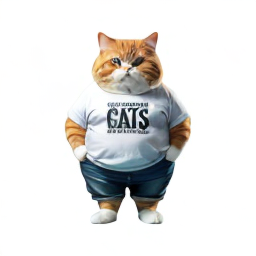

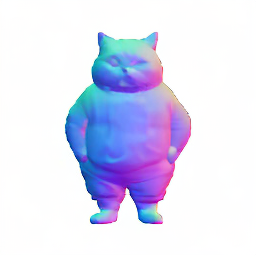

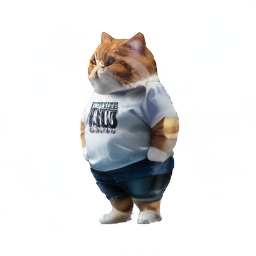

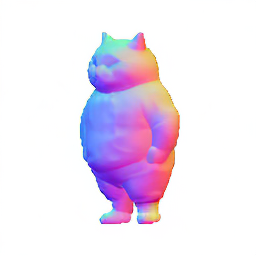

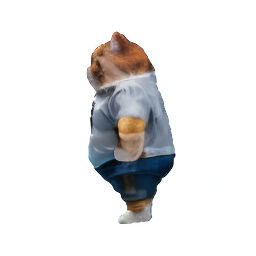

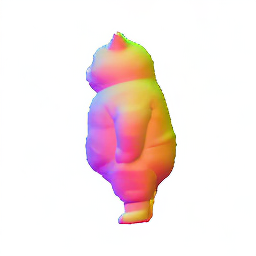

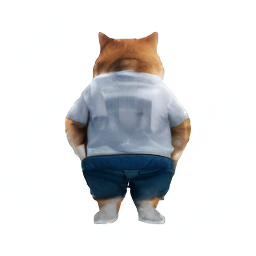

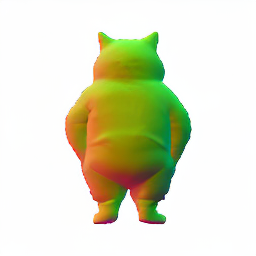

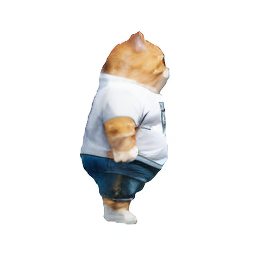

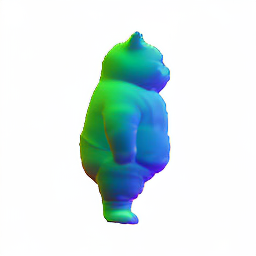

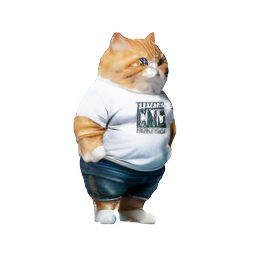

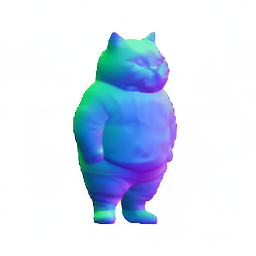

In [ ]:
from IPython.display import display
for img in images:
    display(img)

## Generate a mesh with the images

Approximately 10 minutes

In [ ]:
%cd ./NeuS
!bash run.sh /content/Wonder3D/outputs/cropsize-192-cfg3.0 test
%cd /content/Wonder3D

The mesh is in  /content/Wonder3D/NeuS/exp/neus/test/meshes/

If you want to run the process again with another image, you can do it from the `Select an image` cell.

## Extra: Visualize the resulting mesh

In [ ]:
# Install pyvista for colab
import sys
if 'google.colab' in sys.modules and "pyvista" not in sys.modules:
    !apt install -y xvfb > /dev/null
    !{sys.executable} -m pip install pyvista xvfbwrapper ipygany > /dev/null
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)
    display.start()

import pyvista
# magic trick for white background
pyvista.set_plot_theme("document")

Select the mesh file

In [ ]:
file_path = "/content/Wonder3D/NeuS/exp/neus/test/meshes/00001537.ply"
mesh = pyvista.read(file_path)

Static View

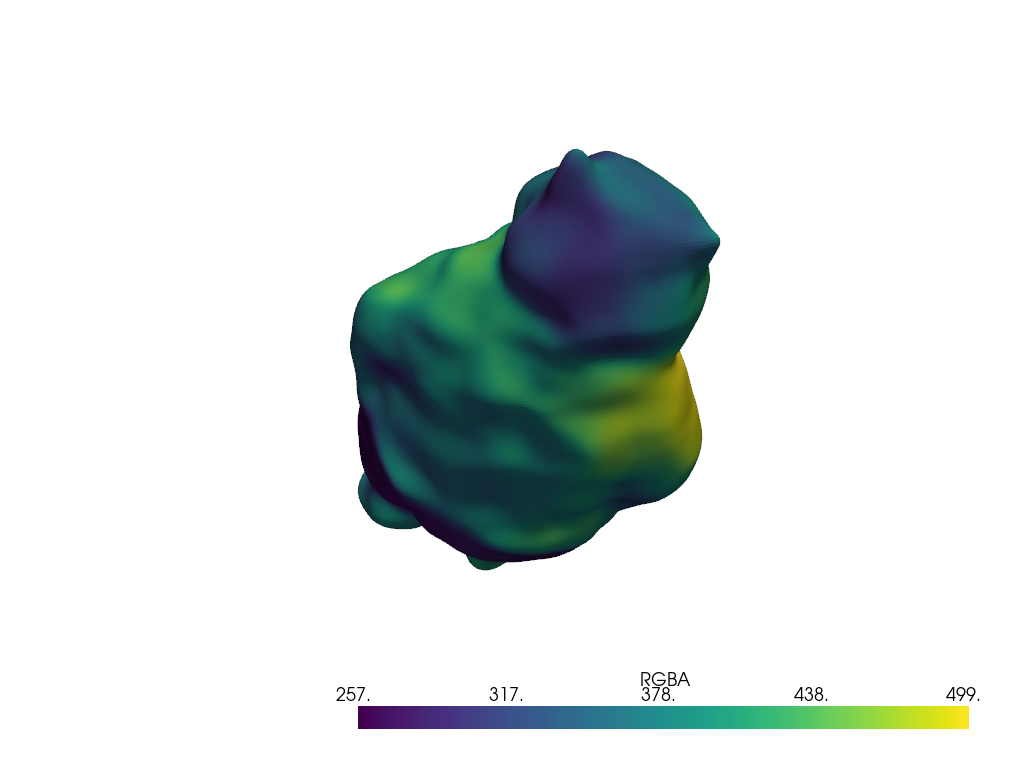

In [ ]:
static_plotter = pyvista.Plotter(notebook=True)
static_plotter.add_mesh(mesh)
static_plotter.show(jupyter_backend="static", return_viewer=True)

Interactive 3D View

In [ ]:
import panel

if 'google.colab' in sys.modules:
    # enable 3rd party Jupyter widgets
    from google.colab import output
    output.enable_custom_widget_manager()

panel.extension("vtk")

panel_plotter = pyvista.Plotter(notebook=True)
panel_plotter.add_mesh(mesh)
panel_plotter._on_first_render_request()
panel.panel(
    panel_plotter.render_window, orientation_widget=panel_plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode="stretch_width"
)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='b10...], sizing_mode='stretch_width')